In [478]:
import torch
import torchtext
import torch.nn as nn
import pandas as pd
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd()
glove = torchtext.vocab.GloVe(name="6B", dim=300) 

In [415]:
def split_headline(headline):
    
    headline = headline.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ") \
                 .replace(":", " : ") \
                 .replace("/", " / ") \
                 .replace("$", " $ ") \
                 .replace("€", " € ") \
                 .replace("(", " ") \
                 .replace(")", " ") \
                 .replace("-", " ") \
                 .replace("~", " ") \
                 .replace("'", "")
    return headline.lower().split()

def get_ML_data(glove):
    train, valid, test = [], [], []
    df = pd.read_csv('final_input.csv').drop(['Date'], axis=1)
    for i, line in enumerate(df.values):
        headline = str(line[0])
        word_index = [glove.stoi[w]        
                for w in split_headline(headline)
                if w in glove.stoi] 
        if not word_index: 
            continue
        word_index = torch.tensor(word_index) 
        label1 = torch.tensor(float(line[1]))
        label2 = torch.tensor(float(line[2]))
        label3 = torch.tensor(float(line[3]))
        label4 = torch.tensor(float(line[4]))
        label5 = torch.tensor(float(line[5]))
        label6 = torch.tensor(float(line[6]))
        labels = torch.tensor([label1, label2, label3, label4, label5, label6])
        if i % 5 < 3:
            train.append((word_index, labels))
        elif i % 5 == 4:
            valid.append((word_index, labels))
        else:
            test.append((word_index, labels))
    return train, valid, test

train, valid, test = get_ML_data(glove)

KeyboardInterrupt: 

In [337]:
from torch.nn.utils.rnn import pad_sequence

train_data = []
valid_data = []
test_data = []
train_labels = []
valid_labels = []
test_labels = []


train_padded = pad_sequence([headline for headline, labels in train],
                            batch_first=True)
for headline, labels in train:
    train_labels.append(labels)
    
valid_padded = pad_sequence([headline for headline, labels in valid],
                            batch_first=True)
for headline, labels in valid:
    valid_labels.append(labels)
    
test_padded = pad_sequence([headline for headline, labels in test],
                            batch_first=True)
for headline, labels in test:
    test_labels.append(labels)
    
for i in range(len(train_labels)):
    train_data.append((train_padded[i], train_labels[i]))
    
for i in range(len(valid_labels)):
    valid_data.append((valid_padded[i], valid_labels[i]))
    
for i in range(len(test_labels)):
    test_data.append((test_padded[i], test_labels[i]))

In [472]:
def get_error(model, data):
    for headlines, labels in data:
        output = (model(headlines))        
        error = np.square(np.subtract(labels,output.detach().numpy())).mean() 
    return error

In [523]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5, batch_size = 11):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = torch.utils.data.DataLoader(train, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, 
                                           batch_size=batch_size, 
                                           shuffle=True)
    epochs, losses, train_err, valid_err = [], [], [], []
    n=0
    
    for epoch in range(num_epochs):
        for headlines, labels in train:
            optimizer.zero_grad()
            pred = model(headlines.unsqueeze(0))
            loss = criterion(pred, labels.float())
            loss.backward()
            optimizer.step()
        losses.append(float(loss))
        
        
        epochs.append(epoch)
        train_err.append(get_error(model, train_loader))
        valid_err.append(get_error(model, valid_loader))
        print("Epoch %d; Loss %f; Train Err %f; Val Err %f" % (
            epoch+1, loss, train_err[-1], valid_err[-1]))
        
    
        if (epoch + 1) % 5 == 0:
            torch.save(model, cwd + '\\Checkpoint.pth' + str(n))
            n += 1
            
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    plt.title("Error Curve")
    plt.plot(epochs, train_err, label="Train")
    plt.plot(epochs, valid_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.106131; Train Err 0.028224; Val Err 0.052100
Epoch 2; Loss 0.093270; Train Err 0.036116; Val Err 0.042317
Epoch 3; Loss 0.082118; Train Err 0.045301; Val Err 0.035290
Epoch 4; Loss 0.072747; Train Err 0.020936; Val Err 0.030500
Epoch 5; Loss 0.065069; Train Err 0.005140; Val Err 0.027409
Epoch 6; Loss 0.058939; Train Err 0.011992; Val Err 0.025518
Epoch 7; Loss 0.054123; Train Err 0.022253; Val Err 0.024408
Epoch 8; Loss 0.050318; Train Err 0.013555; Val Err 0.023769
Epoch 9; Loss 0.047216; Train Err 0.010445; Val Err 0.023402
Epoch 10; Loss 0.044566; Train Err 0.018402; Val Err 0.023184


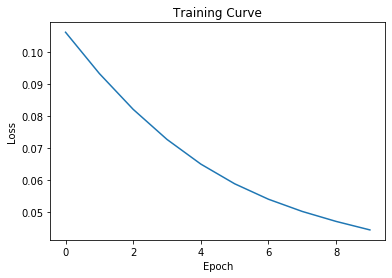

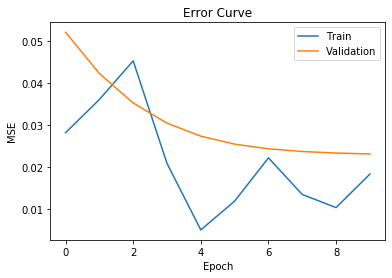

In [524]:
class Exch_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Exch_LSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model_lstm = Exch_LSTM(300, 300, 6)
train_rnn_network(model_lstm, train_data, valid_data, num_epochs=10, learning_rate=2e-5)

In [324]:
def headline_to_index(headline):
    word_index = [glove.stoi[w]        
        for w in split_headline(headline)
                        if w in glove.stoi] 
    if not word_index: 
        pass
    word_index = torch.tensor(word_index) 
    return word_index.unsqueeze(0)

In [333]:
headline = headline_to_index("Big Brain Moment! @#*&^%&")

model_lstm(headline)


tensor([[0.0424, 0.0533, 0.0567, 0.0502, 0.0456, 0.0505]],
       grad_fn=<AddmmBackward>)